Final Project : Sunglasses or eye-based filter – handling eye alignment and occlusion

## CS445: Computational Photography

# Setup


In [50]:
# from google.colab import drive
# drive.mount('/content/drive')

In [51]:
!pwd

/Users/tusharkhosla/miniforge3/envs/cs445/projFinal


In [52]:
# modify to where you store your project data including utils
# datadir = "/Users/tusharkhosla/miniforge3/envs/cs445/proj5/tushproj5/mp5/" 

datadir = "/Users/tusharkhosla/miniforge3/envs/cs445/projFinal/tushproj5/mp5/"

projDatadir = "/Users/tusharkhosla/miniforge3/envs/cs445/projFinal/"

utilfn = datadir + "utils.py"
!cp "$utilfn" .
imagesfn = datadir + "images"
!cp -r "$imagesfn" .

In [53]:
!pip install opencv-python
!pip install opencv-contrib-python
# downgrade OpenCV a bit to use SIFT
# !pip install opencv-contrib-python==3.4.2.17 --force-reinstall
!pip install ffmpeg-python # for converting to video
!pip install mediapipe

import ffmpeg
import cv2
import numpy as np
import os
from numpy.linalg import svd, inv
import utils
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import Video
import cv2
import mediapipe as mp
import numpy as np
from PIL import Image

Video opened successfully.


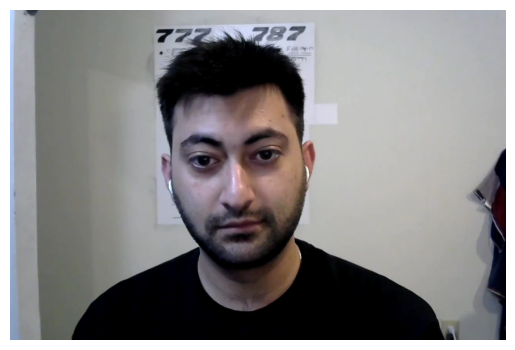

In [54]:
# Path to your video file
video_path1 = projDatadir + 'tusharHeadMove.mp4'  # Replace with your actual filename

# Open video file
cap = cv2.VideoCapture(video_path1)

if not cap.isOpened():
    print("Error: Could not open video.")
else:
    print("Video opened successfully.")

# Read and display the first frame
ret, frame = cap.read()
if ret:
    # Convert BGR (OpenCV) to RGB (matplotlib)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Show the frame
    plt.imshow(frame_rgb)
    plt.title('')
    plt.axis('off')
    plt.show()
else:
    print("Error: Couldn't read a frame.")

# Don't forget to release the video capture when done
cap.release()

In [55]:
# Video(video_path1, width=400, embed=True)

# Initial Attempt at Sunglass Filter

In [56]:
# Initialize mediapipe face mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1)

# Load sunglasses image with transparency (PNG)
sunglasses = Image.open(projDatadir + "sunglasses.png")  # Must have alpha channel

# # Video paths
input_path = projDatadir + 'tusharHeadMove.mp4'
output_path = projDatadir + "output_with_sunglasses.mp4"

# # Open input and get video info
cap = cv2.VideoCapture(input_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
w, h = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# # Output writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            # Get eye corners (landmarks 33 and 263)
            left_eye = face_landmarks.landmark[33]
            right_eye = face_landmarks.landmark[263]

            # Convert normalized to pixel coordinates
            lx, ly = int(left_eye.x * w), int(left_eye.y * h)
            rx, ry = int(right_eye.x * w), int(right_eye.y * h)

            # Compute angle, scale, and position
            dx, dy = rx - lx, ry - ly
            angle = np.degrees(np.arctan2(dy, dx))
            eye_distance = int(np.hypot(dx, dy))
            sunglass_width = int(eye_distance * 2.0)

            # Resize and rotate sunglasses
            resized = sunglasses.resize((sunglass_width, int(sunglass_width * sunglasses.size[1] / sunglasses.size[0])), resample=Image.LANCZOS)
            rotated = resized.rotate(-angle, expand=True)

            # Compute placement
            center_x, center_y = (lx + rx) // 2, (ly + ry) // 2
            x1 = center_x - rotated.width // 2
            y1 = center_y - rotated.height // 2

            # Paste sunglasses onto frame
            pil_frame = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            pil_frame.paste(rotated, (x1, y1), rotated)

            frame = cv2.cvtColor(np.array(pil_frame), cv2.COLOR_RGB2BGR)

    out.write(frame)

cap.release()
out.release()


I0000 00:00:1746919003.510613 21660581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1 Pro
W0000 00:00:1746919003.521105 22652536 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746919003.525454 22652539 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Video opened successfully.


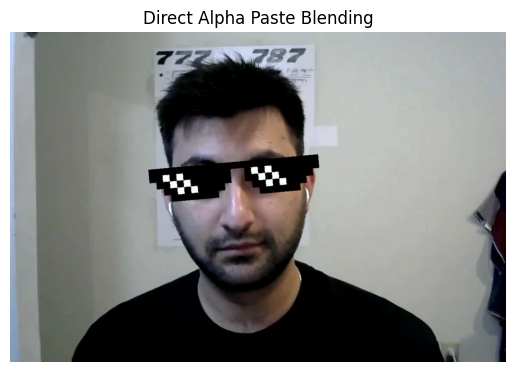

In [57]:
# Path to your video file
video_path2 = projDatadir + 'output_with_sunglasses.mp4'  # Replace with your actual filename

# Open video file
cap = cv2.VideoCapture(video_path2)

if not cap.isOpened():
    print("Error: Could not open video.")
else:
    print("Video opened successfully.")

# Read and display the first frame
ret, frame = cap.read()
if ret:
    # Convert BGR (OpenCV) to RGB (matplotlib)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Show the frame
    plt.imshow(frame_rgb)
    plt.title('Direct Alpha Paste Blending')
    plt.axis('off')
    plt.show()
else:
    print("Error: Couldn't read a frame.")

# Don't forget to release the video capture when done
cap.release()

In [58]:
# Video(video_path2, width=400, embed=True)

# Smoothening and Jitter removal for Sunglass Filter

In [59]:
# Initialize mediapipe face mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1)

# Load sunglasses image with transparency (PNG)
sunglasses = Image.open(projDatadir + "sunglasses.png")  # Ensure it has an alpha channel

# Video paths
input_path = projDatadir + 'tusharHeadMove.mp4'
output_path = projDatadir + "output_with_sunglasses_smoothed.mp4"

# Open input and get video info
cap = cv2.VideoCapture(input_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
w, h = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Output writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

# Smoothing parameters
alpha = 0.5  # Higher = smoother but more lag

# Initialize smoothed values
smoothed_lx = smoothed_ly = smoothed_rx = smoothed_ry = None
smoothed_angle = None
smoothed_eye_distance = None

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            # Get eye corners (landmarks 33 and 263)
            left_eye = face_landmarks.landmark[33]
            right_eye = face_landmarks.landmark[263]

            # Convert to pixel coordinates
            lx, ly = int(left_eye.x * w), int(left_eye.y * h)
            rx, ry = int(right_eye.x * w), int(right_eye.y * h)

            # Initialize or smooth
            if smoothed_lx is None:
                smoothed_lx, smoothed_ly = lx, ly
                smoothed_rx, smoothed_ry = rx, ry
                dx, dy = rx - lx, ry - ly
                smoothed_angle = np.degrees(np.arctan2(dy, dx))
                smoothed_eye_distance = np.hypot(dx, dy)
            else:
                smoothed_lx = alpha * smoothed_lx + (1 - alpha) * lx
                smoothed_ly = alpha * smoothed_ly + (1 - alpha) * ly
                smoothed_rx = alpha * smoothed_rx + (1 - alpha) * rx
                smoothed_ry = alpha * smoothed_ry + (1 - alpha) * ry

                dx = smoothed_rx - smoothed_lx
                dy = smoothed_ry - smoothed_ly

                angle = np.degrees(np.arctan2(dy, dx))
                smoothed_angle = alpha * smoothed_angle + (1 - alpha) * angle

                eye_distance = np.hypot(dx, dy)
                smoothed_eye_distance = alpha * smoothed_eye_distance + (1 - alpha) * eye_distance

            # Resize and rotate sunglasses
            sunglass_width = int(smoothed_eye_distance * 2.0)
            resized = sunglasses.resize(
                (sunglass_width, int(sunglass_width * sunglasses.size[1] / sunglasses.size[0])),
                resample=Image.LANCZOS
            )
            rotated = resized.rotate(-smoothed_angle, expand=True)

            # Placement point (midpoint of smoothed eye coordinates)
            center_x = int((smoothed_lx + smoothed_rx) / 2)
            center_y = int((smoothed_ly + smoothed_ry) / 2)
            x1 = center_x - rotated.width // 2
            y1 = center_y - rotated.height // 2

            # Paste sunglasses
            pil_frame = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            pil_frame.paste(rotated, (x1, y1), rotated)
            frame = cv2.cvtColor(np.array(pil_frame), cv2.COLOR_RGB2BGR)

    out.write(frame)

cap.release()
out.release()


I0000 00:00:1746919007.783110 21660581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1 Pro
W0000 00:00:1746919007.784592 22652606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746919007.787943 22652606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Video opened successfully.


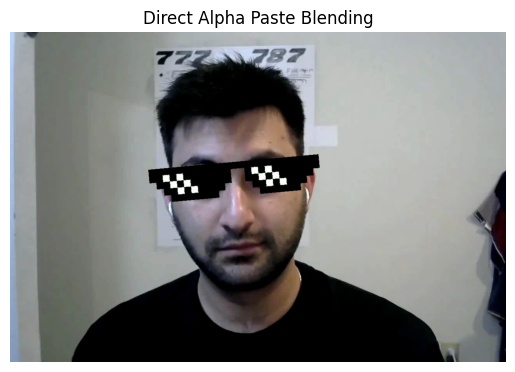

In [60]:
# Path to your video file
video_path3 = projDatadir + 'output_with_sunglasses_smoothed.mp4'  # Replace with your actual filename

# Open video file
cap = cv2.VideoCapture(video_path3)

if not cap.isOpened():
    print("Error: Could not open video.")
else:
    print("Video opened successfully.")

# Read and display the first frame
ret, frame = cap.read()
if ret:
    # Convert BGR (OpenCV) to RGB (matplotlib)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Show the frame
    plt.imshow(frame_rgb)
    plt.title('Direct Alpha Paste Blending')
    plt.axis('off')
    plt.show()
else:
    print("Error: Couldn't read a frame.")

# Don't forget to release the video capture when done
cap.release()

In [61]:
# Video(video_path3, width=400, embed=True)

 # Comparing Direct Paste v/s Poisson Blending

In [62]:
use_poisson = True  # Set to False to use direct paste

# Initialize mediapipe
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1)

# Load sunglasses image
sunglasses = cv2.imread(projDatadir + "sunglasses.png", cv2.IMREAD_UNCHANGED)

# Video setup
input_path = projDatadir + 'tusharHeadMove.mp4'
output_path = projDatadir + ("output_poisson.mp4" if use_poisson else "output_directpaste.mp4")
cap = cv2.VideoCapture(input_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
w, h = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

# Smoothing
alpha = 0.5
smoothed_lx = smoothed_ly = smoothed_rx = smoothed_ry = None
smoothed_angle = smoothed_eye_distance = None

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            lx, ly = int(face_landmarks.landmark[33].x * w), int(face_landmarks.landmark[33].y * h)
            rx, ry = int(face_landmarks.landmark[263].x * w), int(face_landmarks.landmark[263].y * h)

            if smoothed_lx is None:
                smoothed_lx, smoothed_ly = lx, ly
                smoothed_rx, smoothed_ry = rx, ry
                dx, dy = rx - lx, ry - ly
                smoothed_angle = np.degrees(np.arctan2(dy, dx))
                smoothed_eye_distance = np.hypot(dx, dy)
            else:
                smoothed_lx = alpha * smoothed_lx + (1 - alpha) * lx
                smoothed_ly = alpha * smoothed_ly + (1 - alpha) * ly
                smoothed_rx = alpha * smoothed_rx + (1 - alpha) * rx
                smoothed_ry = alpha * smoothed_ry + (1 - alpha) * ry
                dx = smoothed_rx - smoothed_lx
                dy = smoothed_ry - smoothed_ly
                angle = np.degrees(np.arctan2(dy, dx))
                smoothed_angle = alpha * smoothed_angle + (1 - alpha) * angle
                eye_distance = np.hypot(dx, dy)
                smoothed_eye_distance = alpha * smoothed_eye_distance + (1 - alpha) * eye_distance

            # Resize and rotate
            sunglass_width = int(smoothed_eye_distance * 2.0)
            aspect_ratio = sunglasses.shape[0] / sunglasses.shape[1]
            sunglass_height = int(sunglass_width * aspect_ratio)
            resized = cv2.resize(sunglasses, (sunglass_width, sunglass_height), interpolation=cv2.INTER_LANCZOS4)
            sunglass_rgb = resized[:, :, :3]
            sunglass_mask = resized[:, :, 3]

            # Rotate using affine transform
            M = cv2.getRotationMatrix2D((sunglass_width // 2, sunglass_height // 2), -smoothed_angle, 1.0)
            sunglass_rgb = cv2.warpAffine(sunglass_rgb, M, (sunglass_width, sunglass_height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
            sunglass_mask = cv2.warpAffine(sunglass_mask, M, (sunglass_width, sunglass_height), flags=cv2.INTER_LINEAR)

            center_x = int((smoothed_lx + smoothed_rx) / 2)
            center_y = int((smoothed_ly + smoothed_ry) / 2)

            if use_poisson:
                # Prepare for Poisson
                mask = cv2.merge([sunglass_mask]*3)
                center = (center_x, center_y)
                frame = cv2.seamlessClone(sunglass_rgb, frame, mask, center, cv2.NORMAL_CLONE)
            else:
                # Direct paste with alpha
                x1 = center_x - sunglass_rgb.shape[1] // 2
                y1 = center_y - sunglass_rgb.shape[0] // 2
                overlay = frame.copy()
                for c in range(3):
                    overlay[y1:y1+sunglass_rgb.shape[0], x1:x1+sunglass_rgb.shape[1], c] = \
                        sunglass_rgb[:, :, c] * (sunglass_mask/255.0) + \
                        overlay[y1:y1+sunglass_rgb.shape[0], x1:x1+sunglass_rgb.shape[1], c] * (1.0 - sunglass_mask/255.0)
                frame = overlay

    out.write(frame)

cap.release()
out.release()


I0000 00:00:1746919011.974999 21660581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1 Pro
W0000 00:00:1746919011.976105 22652709 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746919011.979738 22652710 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Video opened successfully.


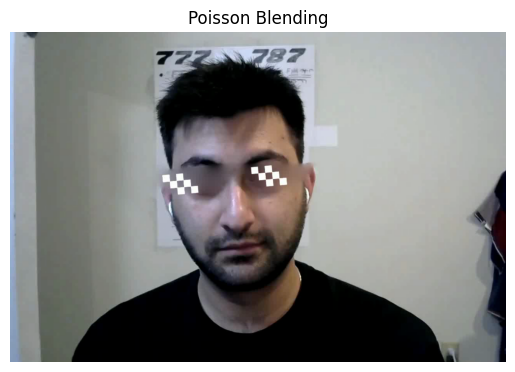

In [63]:
# Path to your video file
video_path4 = projDatadir + 'output_poisson.mp4'  # Replace with your actual filename

# Open video file
cap = cv2.VideoCapture(video_path4)

if not cap.isOpened():
    print("Error: Could not open video.")
else:
    print("Video opened successfully.")

# Read and display the first frame
ret, frame = cap.read()
if ret:
    # Convert BGR (OpenCV) to RGB (matplotlib)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Show the frame
    plt.imshow(frame_rgb)
    plt.title('Poisson Blending')
    plt.axis('off')
    plt.show()
else:
    print("Error: Couldn't read a frame.")

# Don't forget to release the video capture when done
cap.release()

In [64]:
# Video(video_path4, width=400, embed=True)

 # Testing different Eye Tracking Filter

In [65]:
# Initialize mediapipe face mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1)

# Load sunglasses image with transparency (PNG)
sunglasses = Image.open(projDatadir + "googly.png")  # Ensure it has an alpha channel

# Video paths
input_path = projDatadir + 'tusharHeadMove.mp4'
output_path = projDatadir + "output_with_googly_smoothed.mp4"

# Open input and get video info
cap = cv2.VideoCapture(input_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
w, h = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Output writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

# Smoothing parameters
alpha = 0.5  # Higher = smoother but more lag

# Initialize smoothed values
smoothed_lx = smoothed_ly = smoothed_rx = smoothed_ry = None
smoothed_angle = None
smoothed_eye_distance = None

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            # Get eye corners (landmarks 33 and 263)
            left_eye = face_landmarks.landmark[33]
            right_eye = face_landmarks.landmark[263]

            # Convert to pixel coordinates
            lx, ly = int(left_eye.x * w), int(left_eye.y * h)
            rx, ry = int(right_eye.x * w), int(right_eye.y * h)

            # Initialize or smooth
            if smoothed_lx is None:
                smoothed_lx, smoothed_ly = lx, ly
                smoothed_rx, smoothed_ry = rx, ry
                dx, dy = rx - lx, ry - ly
                smoothed_angle = np.degrees(np.arctan2(dy, dx))
                smoothed_eye_distance = np.hypot(dx, dy)
            else:
                smoothed_lx = alpha * smoothed_lx + (1 - alpha) * lx
                smoothed_ly = alpha * smoothed_ly + (1 - alpha) * ly
                smoothed_rx = alpha * smoothed_rx + (1 - alpha) * rx
                smoothed_ry = alpha * smoothed_ry + (1 - alpha) * ry

                dx = smoothed_rx - smoothed_lx
                dy = smoothed_ry - smoothed_ly

                angle = np.degrees(np.arctan2(dy, dx))
                smoothed_angle = alpha * smoothed_angle + (1 - alpha) * angle

                eye_distance = np.hypot(dx, dy)
                smoothed_eye_distance = alpha * smoothed_eye_distance + (1 - alpha) * eye_distance

            # Resize and rotate sunglasses
            sunglass_width = int(smoothed_eye_distance * 2.0)
            resized = sunglasses.resize(
                (sunglass_width, int(sunglass_width * sunglasses.size[1] / sunglasses.size[0])),
                resample=Image.LANCZOS
            )
            rotated = resized.rotate(-smoothed_angle, expand=True)

            # Placement point (midpoint of smoothed eye coordinates)
            center_x = int((smoothed_lx + smoothed_rx) / 2)
            center_y = int((smoothed_ly + smoothed_ry) / 2)
            x1 = center_x - rotated.width // 2
            y1 = center_y - rotated.height // 2

            # Paste sunglasses
            pil_frame = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            pil_frame.paste(rotated, (x1, y1), rotated)
            frame = cv2.cvtColor(np.array(pil_frame), cv2.COLOR_RGB2BGR)

    out.write(frame)

cap.release()
out.release()


I0000 00:00:1746919023.316450 21660581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1 Pro
W0000 00:00:1746919023.317808 22652866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746919023.321868 22652866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Video opened successfully.


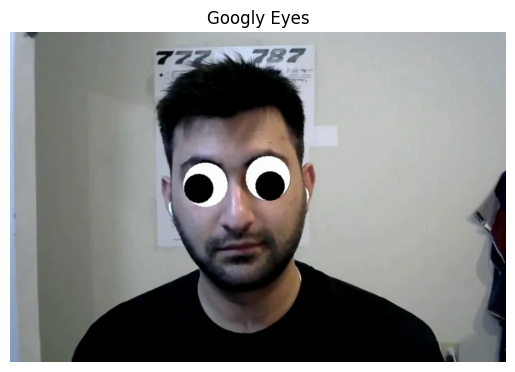

In [66]:
# Path to your video file
video_path5 = projDatadir + 'output_with_googly_smoothed.mp4'  # Replace with your actual filename

# Open video file
cap = cv2.VideoCapture(video_path5)

if not cap.isOpened():
    print("Error: Could not open video.")
else:
    print("Video opened successfully.")

# Read and display the first frame
ret, frame = cap.read()
if ret:
    # Convert BGR (OpenCV) to RGB (matplotlib)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Show the frame
    plt.imshow(frame_rgb)
    plt.title('Googly Eyes')
    plt.axis('off')
    plt.show()
else:
    print("Error: Couldn't read a frame.")

# Don't forget to release the video capture when done
cap.release()

In [67]:
# Video(video_path5, width=400, embed=True)